In [64]:
DATA_DIR="/g/g11/bowen36/mfem/speedups"

In [65]:
# Show top-level speedups as recorded end-to-end with Google benchmark
from pathlib import Path
# /g/g11/bowen36/mfem/speedups/proteus-bench-ceed.tsv
file = Path(DATA_DIR) / "proteus-bench-ceed.tsv"
print(file.read_text())

Benchmark                         Base (ms)     New (ms)    Speedup
----------------------------------------------------------------------
BK1Mass/7                            15.300        1.880       8.14x
BP1Mass/7                           524.000       93.300       5.62x
BK6VectorDiffusion/1                  1.280        0.267       4.79x
BP6VectorDiffusion/1                 42.400        9.970       4.25x
BK2VectorMass/1                       0.863        0.206       4.19x
BP2VectorMass/1                      29.000        7.950       3.65x
BK4VectorDiffusion/3                 31.500        9.170       3.44x
BP4VectorDiffusion/3               1017.000      303.000       3.36x
BK6VectorDiffusion/3                 20.300        6.150       3.30x
BK6VectorDiffusion/4                 43.400       13.400       3.24x
BP6VectorDiffusion/3                660.000      206.000       3.20x
BP6VectorDiffusion/4               1411.000      446.000       3.16x
BK4VectorDiffusion/1             

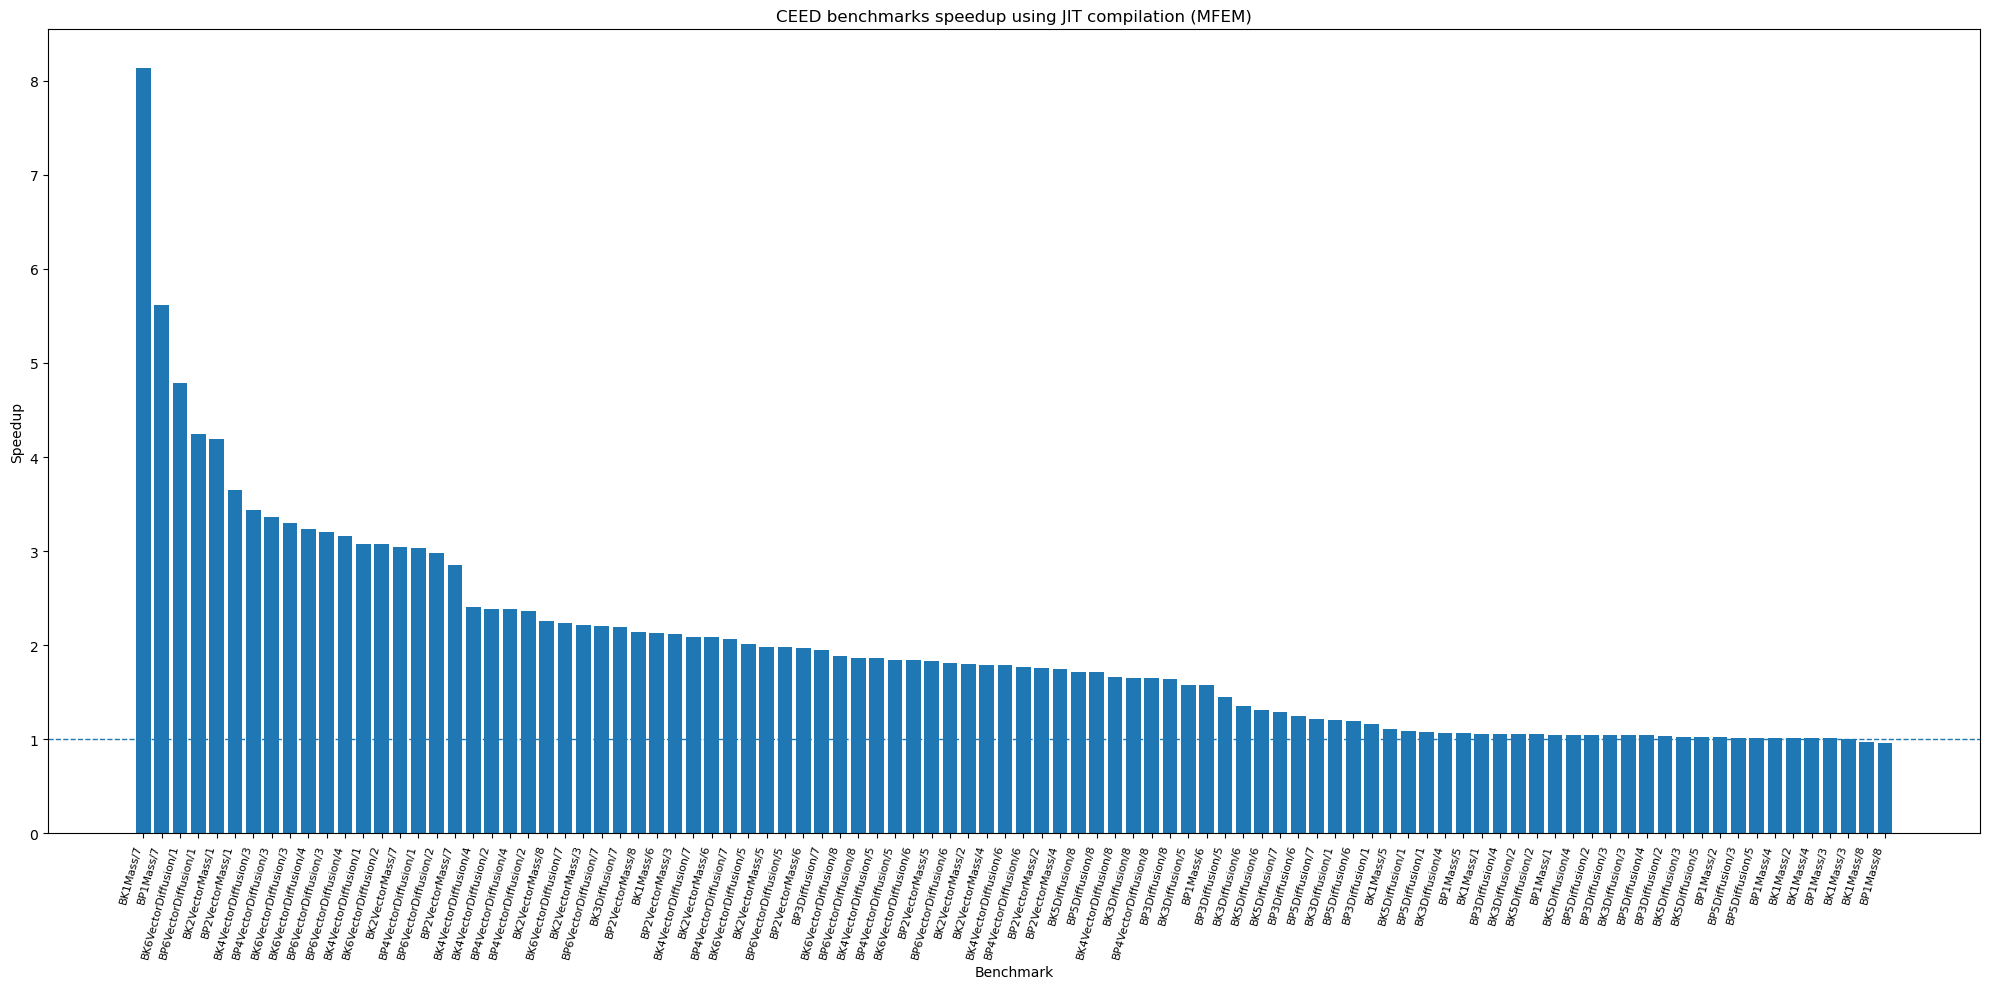

In [66]:
# Plot end-to-end speedups

import matplotlib.pyplot as plt
import pathlib

names = []
speedups = []
raw_data = file.read_text().splitlines()[2:]

for line in raw_data:
    parts = line.split()
    name = parts[0]
    speedup = float(parts[-1].replace("x", ""))
    names.append(name)
    speedups.append(speedup)

# Sort by speedup descending
sorted_data = sorted(zip(names, speedups), key=lambda x: x[1], reverse=True)
names, speedups = zip(*sorted_data)

# Plot
plt.figure(figsize=(20, 10))
plt.bar(names, speedups)
plt.axhline(1.0, linestyle="--", linewidth=1)

plt.ylabel("Speedup")
plt.xlabel("Benchmark")
plt.xticks(rotation=75, ha="right", fontsize=8)
#plt.figure(figsize=(24, 6))
plt.title("CEED benchmarks speedup using JIT compilation (MFEM)")

plt.tight_layout()


                Program  \
7        BK1MassOrder=1   
8        BK1MassOrder=2   
8        BK1MassOrder=3   
0        BK1MassOrder=4   
8        BK1MassOrder=5   
8        BK1MassOrder=6   
8        BK1MassOrder=7   
7   BK3DiffusionOrder=1   
8   BK3DiffusionOrder=2   
8   BK3DiffusionOrder=3   
8   BK3DiffusionOrder=4   
8   BK3DiffusionOrder=5   
8   BK3DiffusionOrder=6   
8   BK3DiffusionOrder=7   
3   BK5DiffusionOrder=1   
8   BK5DiffusionOrder=2   
8   BK5DiffusionOrder=3   
8   BK5DiffusionOrder=4   
8   BK5DiffusionOrder=5   
8   BK5DiffusionOrder=6   
8   BK5DiffusionOrder=7   
23       BP1MassOrder=1   
0        BP1MassOrder=2   
24       BP1MassOrder=3   
24       BP1MassOrder=4   
24       BP1MassOrder=5   
24       BP1MassOrder=6   
24       BP1MassOrder=7   
3   BP3DiffusionOrder=1   
24  BP3DiffusionOrder=2   
9   BP3DiffusionOrder=3   
24  BP3DiffusionOrder=4   
24  BP3DiffusionOrder=5   
24  BP3DiffusionOrder=6   
24  BP3DiffusionOrder=7   
23  BP5DiffusionOrder=1   
1

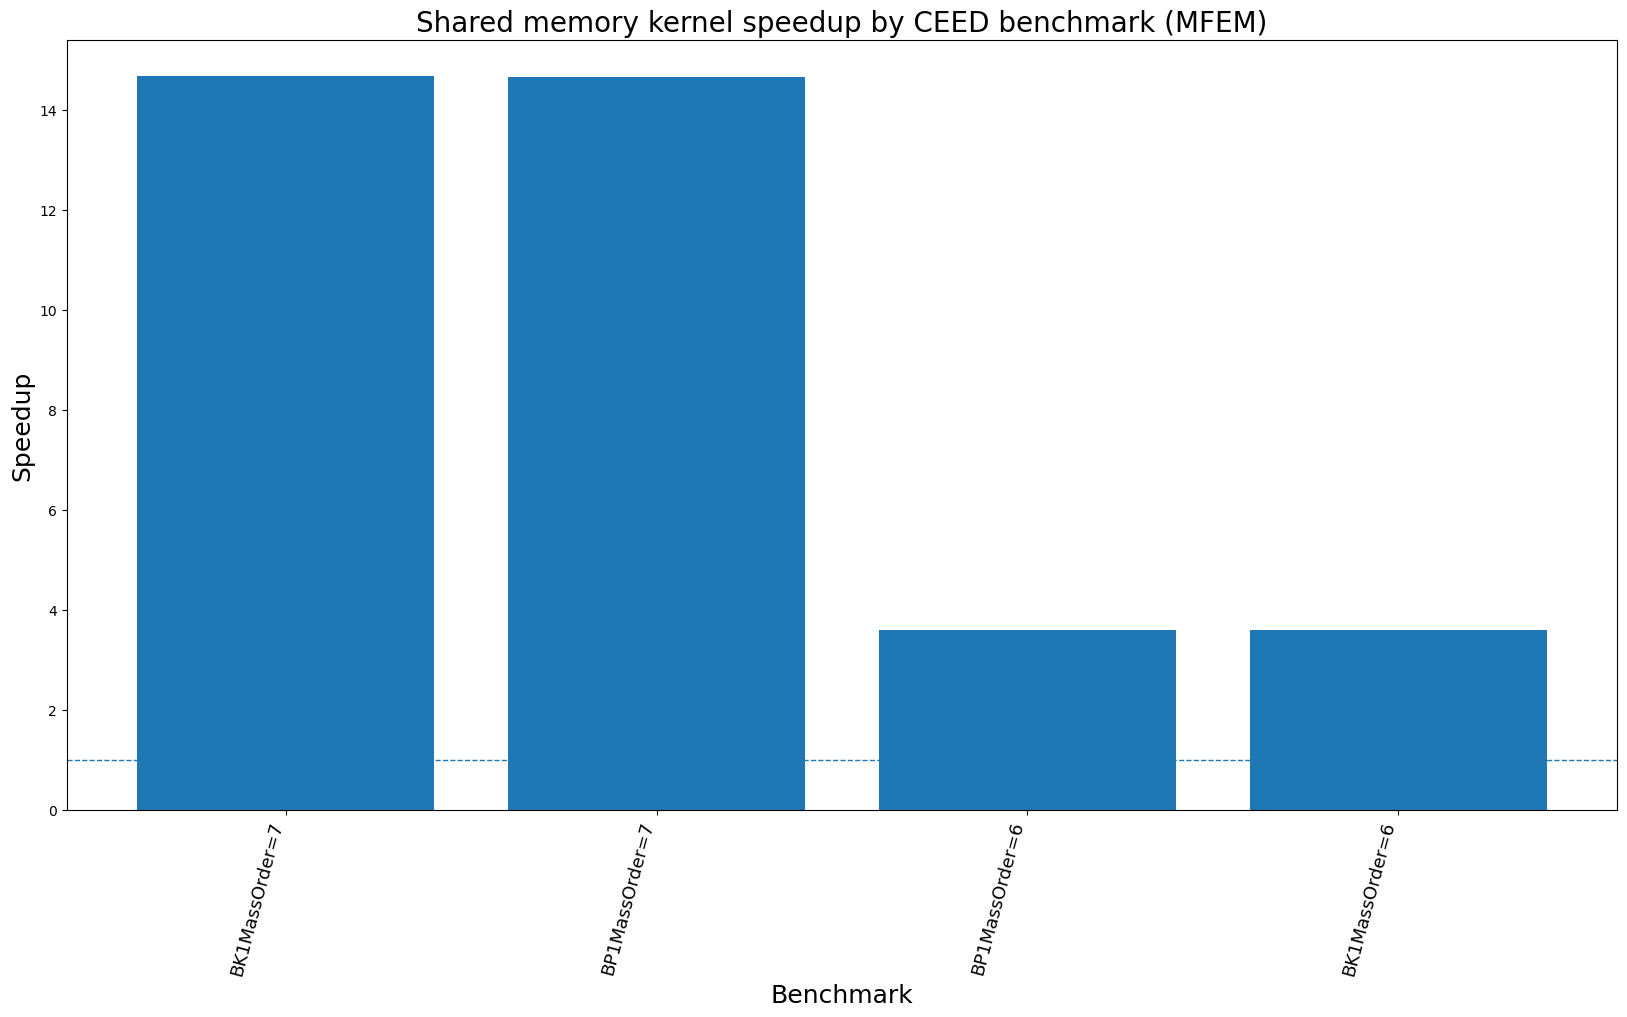

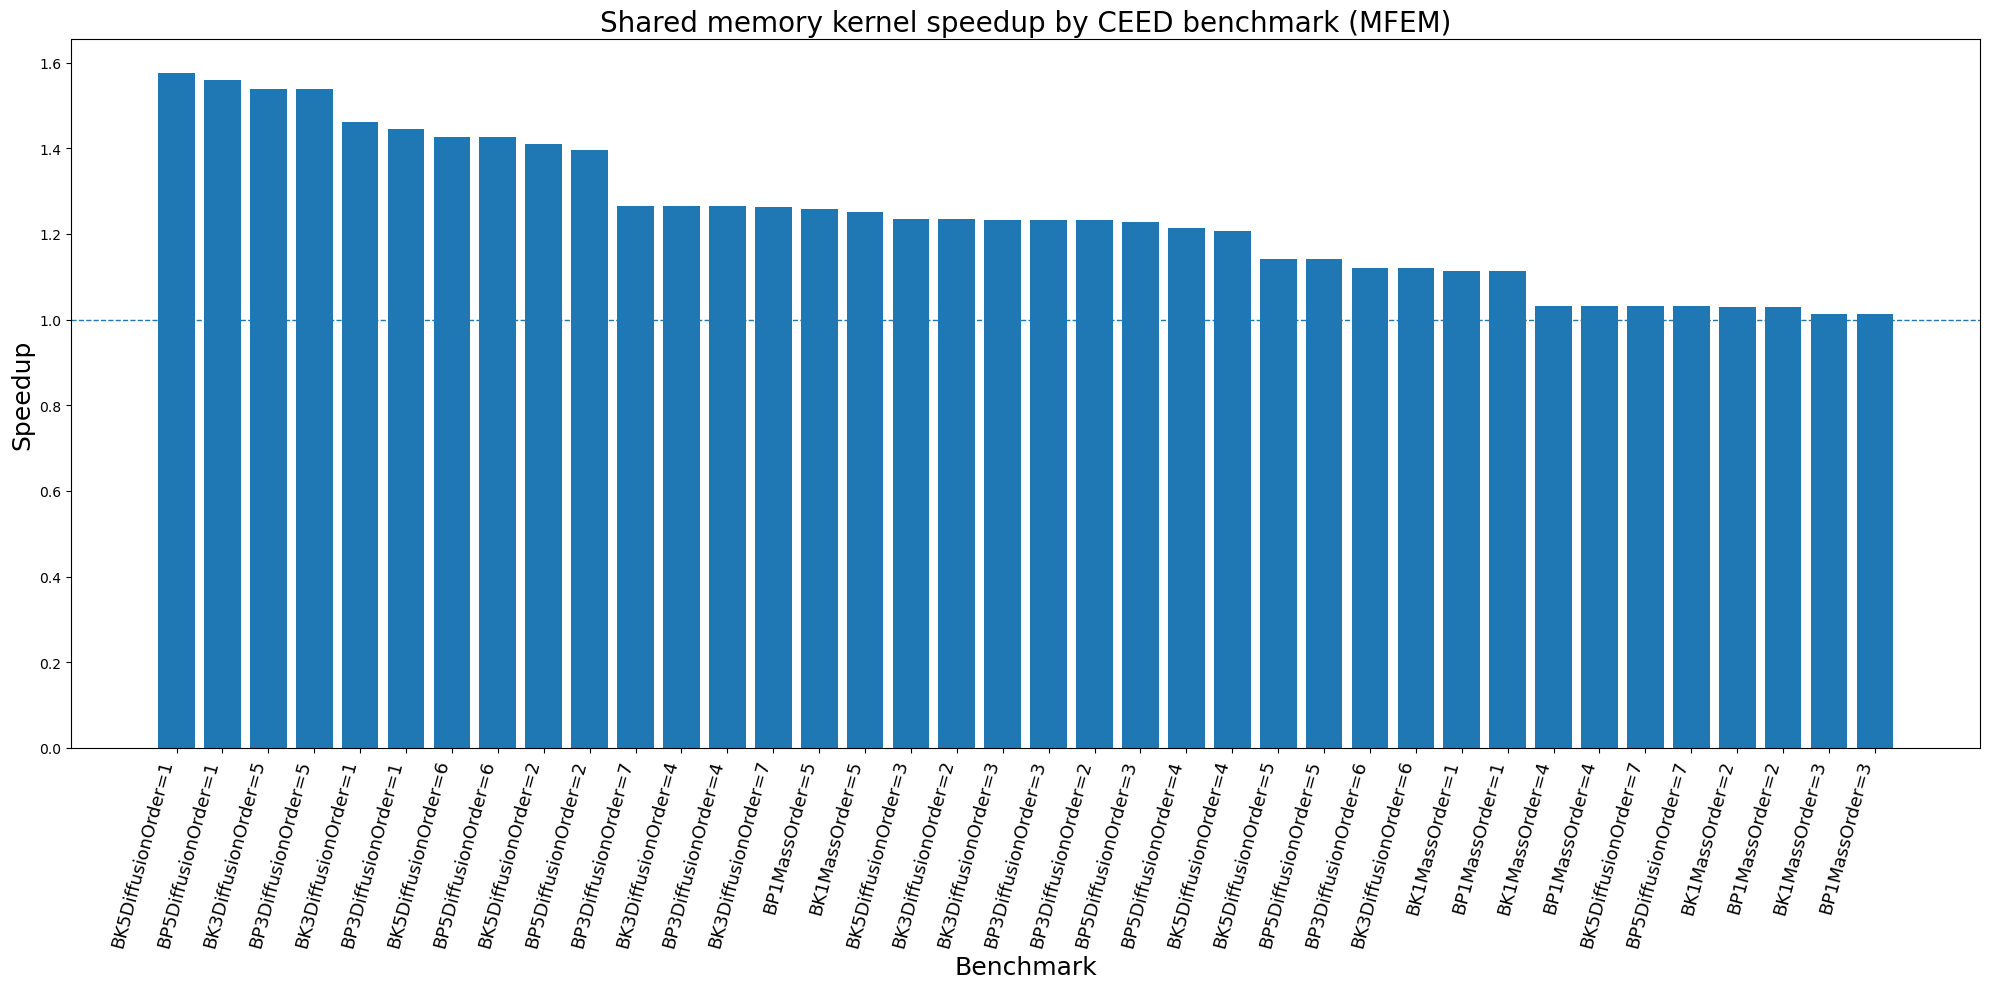

In [67]:
# Let's take a look at all the SMEM kernels that sped up

import pandas as pd
all_speedups = pd.DataFrame()

for file in Path(DATA_DIR).glob("*.csv"):
    tmp = pd.read_csv(file)
    tmp["Program"] = file.stem
    all_speedups = pd.concat([all_speedups,tmp])

all_speedups = all_speedups.dropna()
SMEM_speedups = all_speedups[all_speedups["KernelName"].str.contains("Smem")]
# print(SMEM_speedups)

# Sort by speedup descending
sorted_data = sorted(zip(SMEM_speedups["Program"], SMEM_speedups["Speedup"]), key=lambda x: x[1], reverse=True)
names, speedups = zip(*sorted_data)

# Plot
plt.figure(figsize=(20, 10))
plt.bar(names[:4], speedups[:4])
plt.axhline(1.0, linestyle="--", linewidth=1)

plt.ylabel("Speedup", fontsize=18)
plt.xlabel("Benchmark", fontsize=18)
plt.xticks(rotation=75, ha="right", fontsize=13)
#plt.figure(figsize=(24, 6))
plt.title("Shared memory kernel speedup by CEED benchmark (MFEM)", fontsize=20)

plt.figure(figsize=(20, 10))
plt.bar(names[4:], speedups[4:])
plt.axhline(1.0, linestyle="--", linewidth=1)

plt.ylabel("Speedup", fontsize=18)
plt.xlabel("Benchmark", fontsize=18)
plt.xticks(rotation=75, ha="right", fontsize=13)
#plt.figure(figsize=(24, 6))
plt.title("Shared memory kernel speedup by CEED benchmark (MFEM)", fontsize=20)

plt.tight_layout()

# Legend
print(SMEM_speedups[["Program", "KernelName"]])

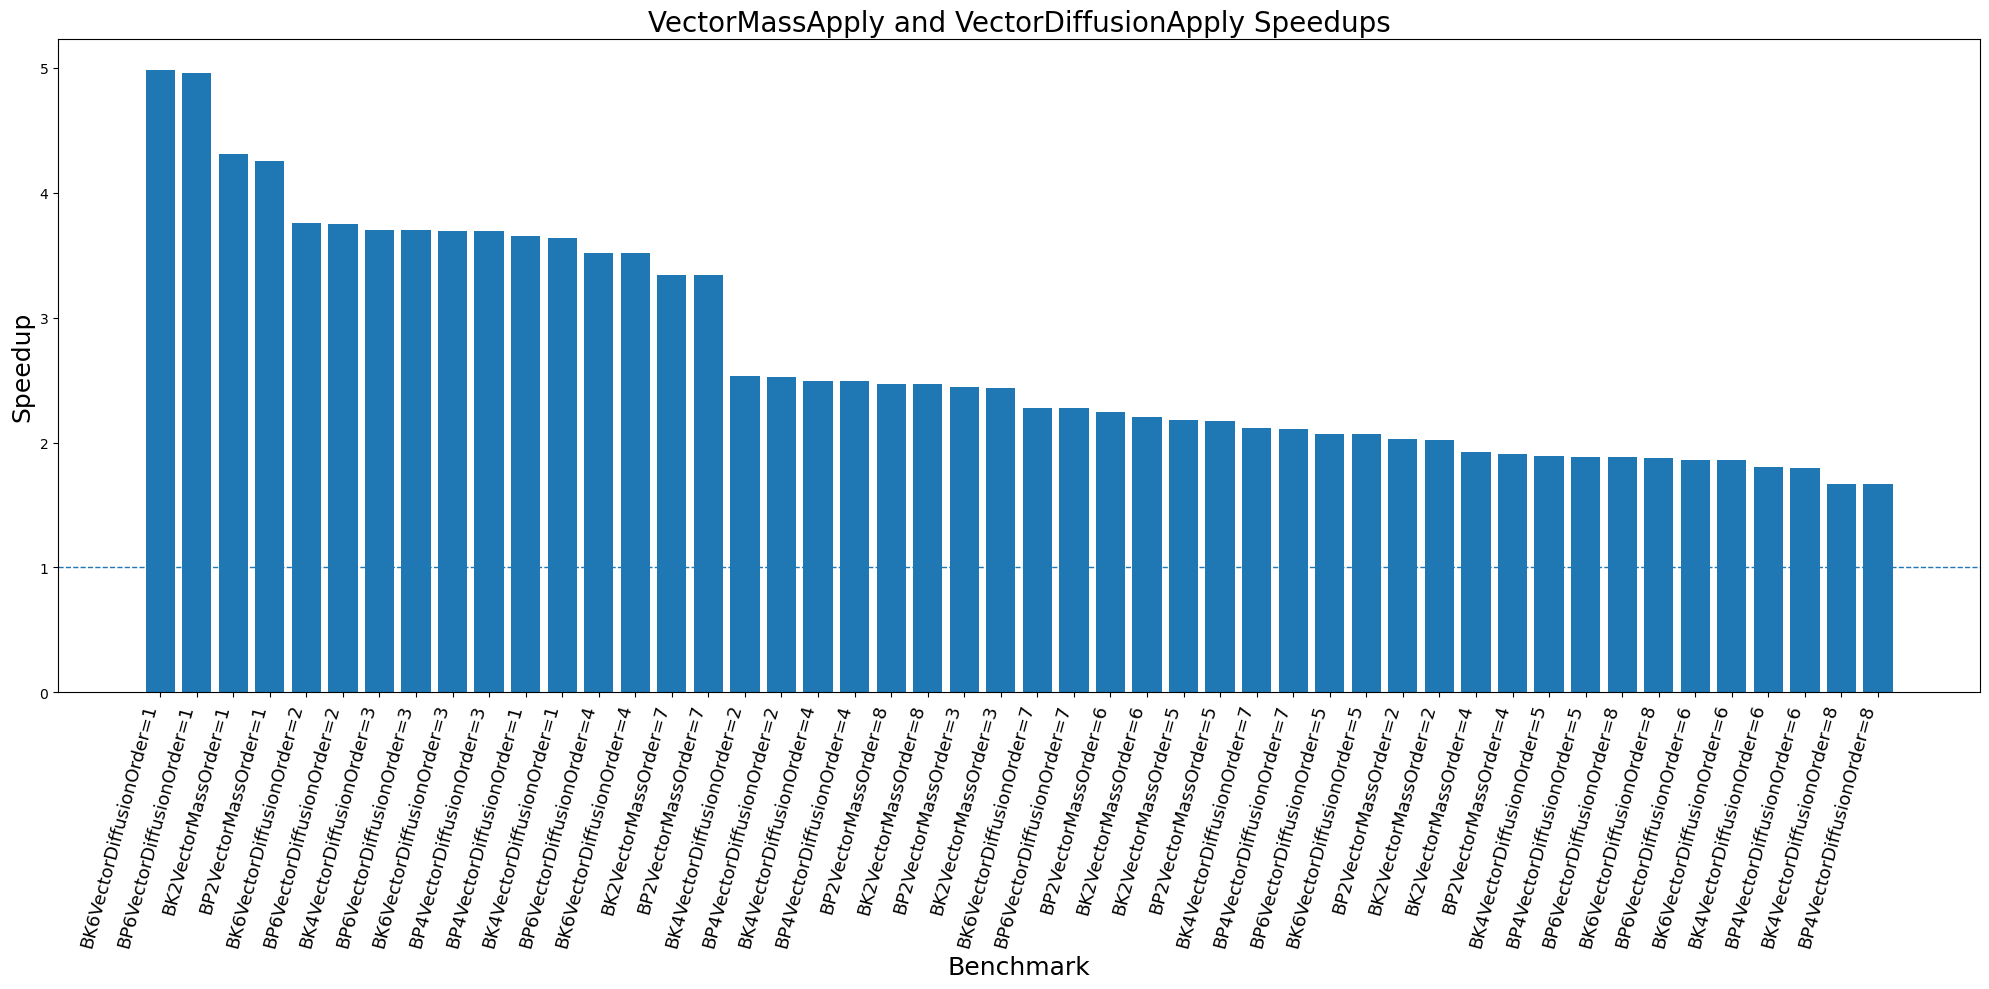

In [68]:
vec_speedups = all_speedups[
                              all_speedups["KernelName"].str.contains("VectorMassApply") |
                              all_speedups["KernelName"].str.contains("VectorDiffusionApply") 
                            ]

pd.set_option('display.max_colwidth', None)
sort_and_plot_df(vec_speedups, "VectorMassApply and VectorDiffusionApply Speedups")

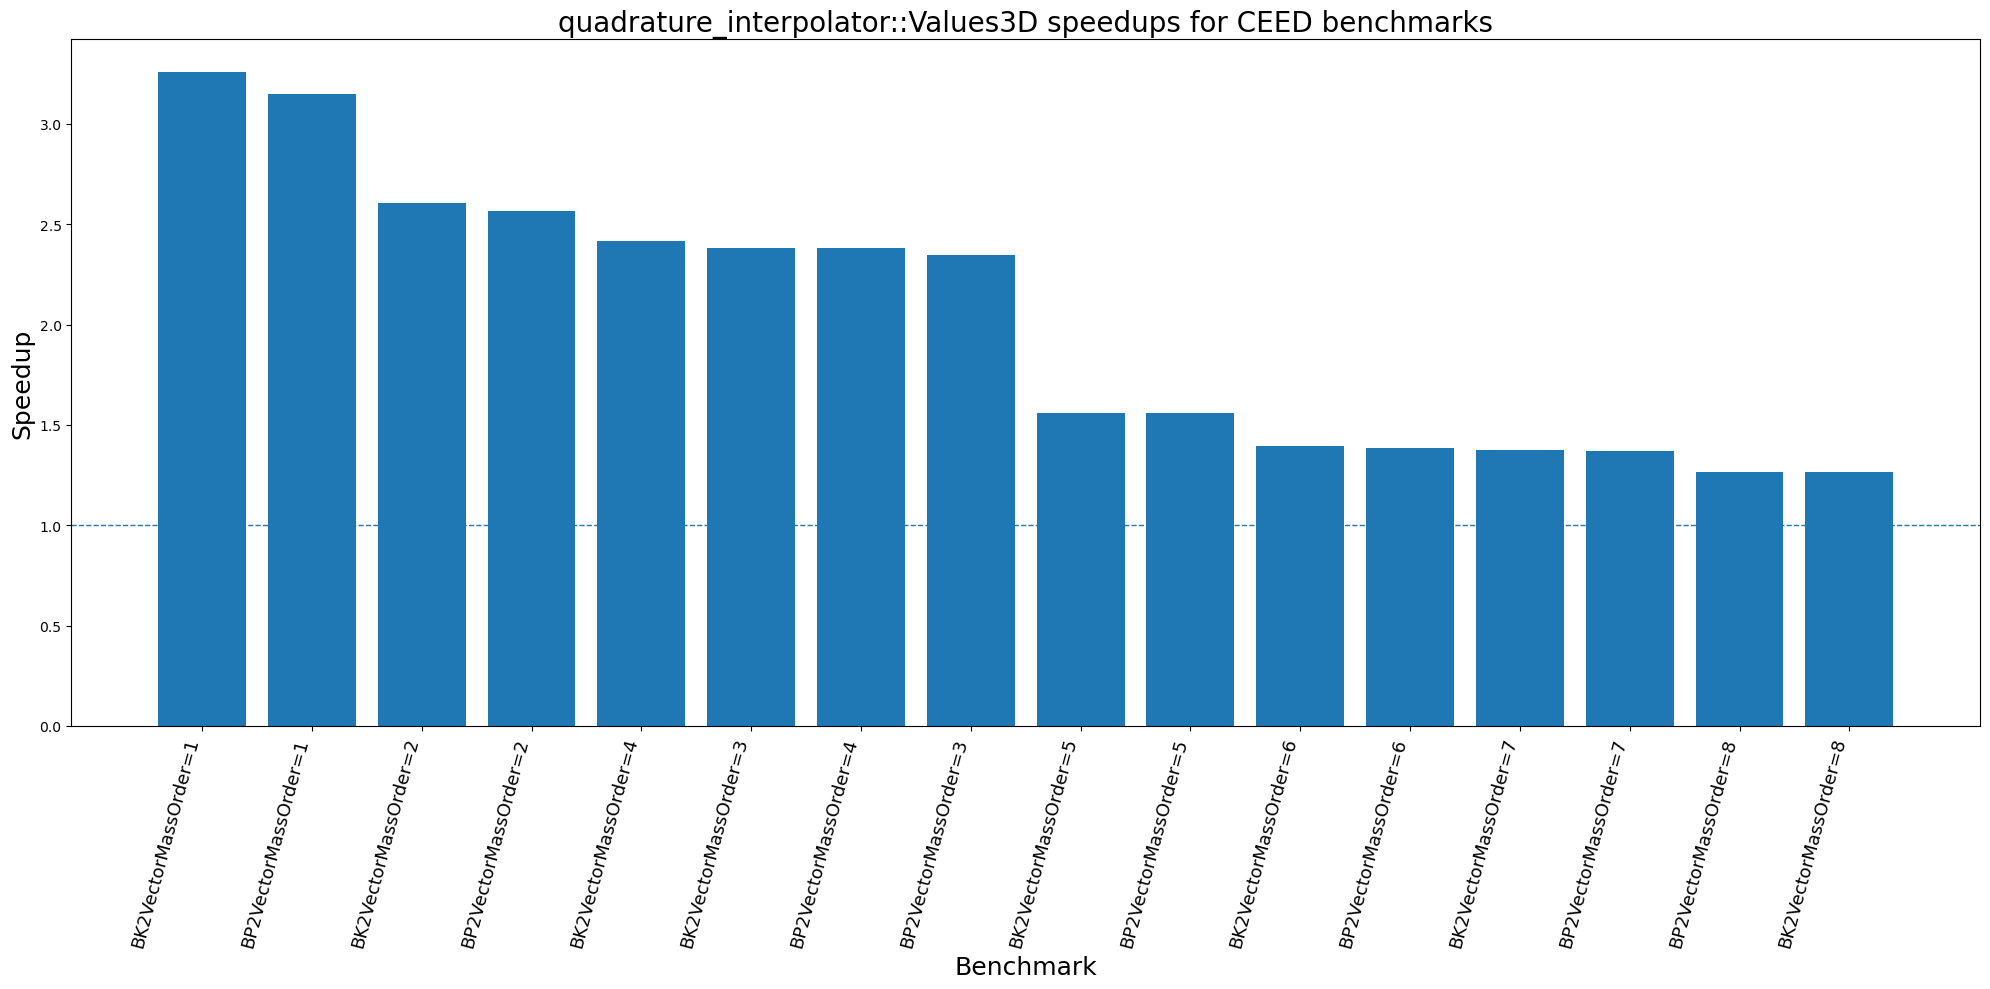

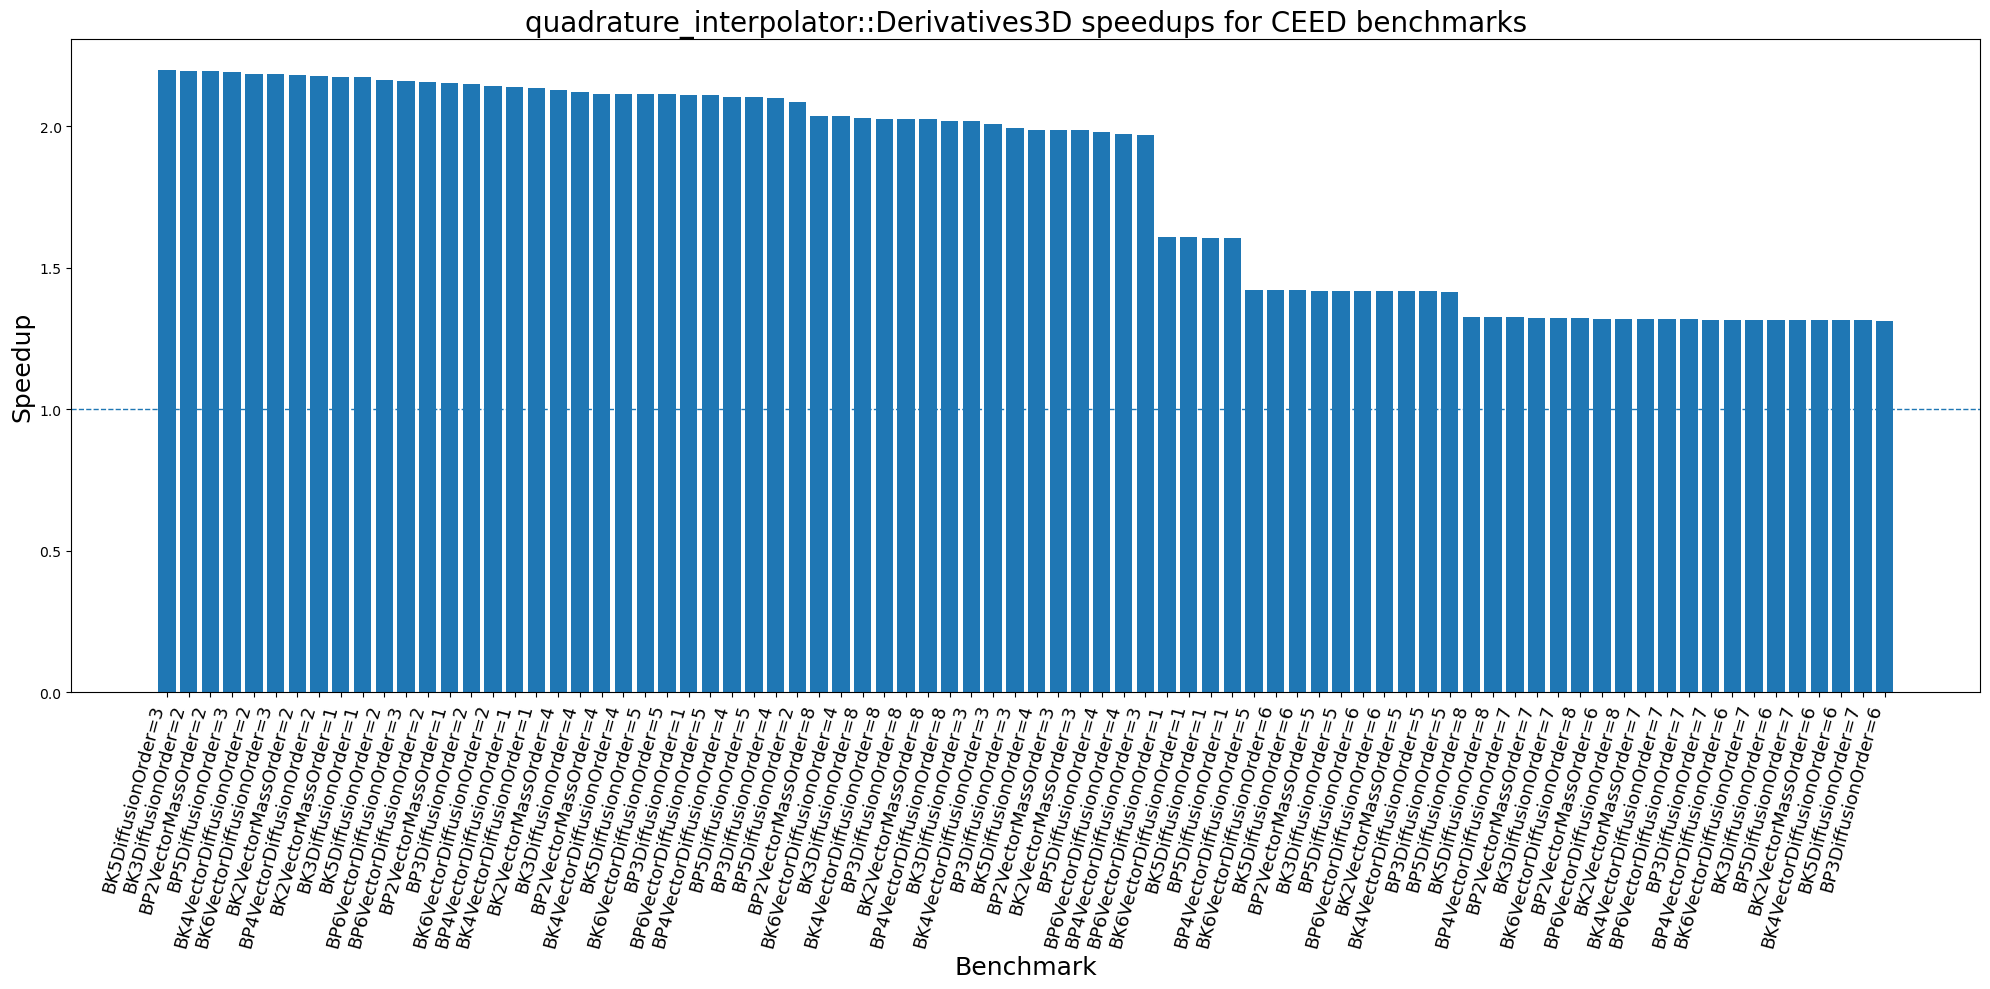

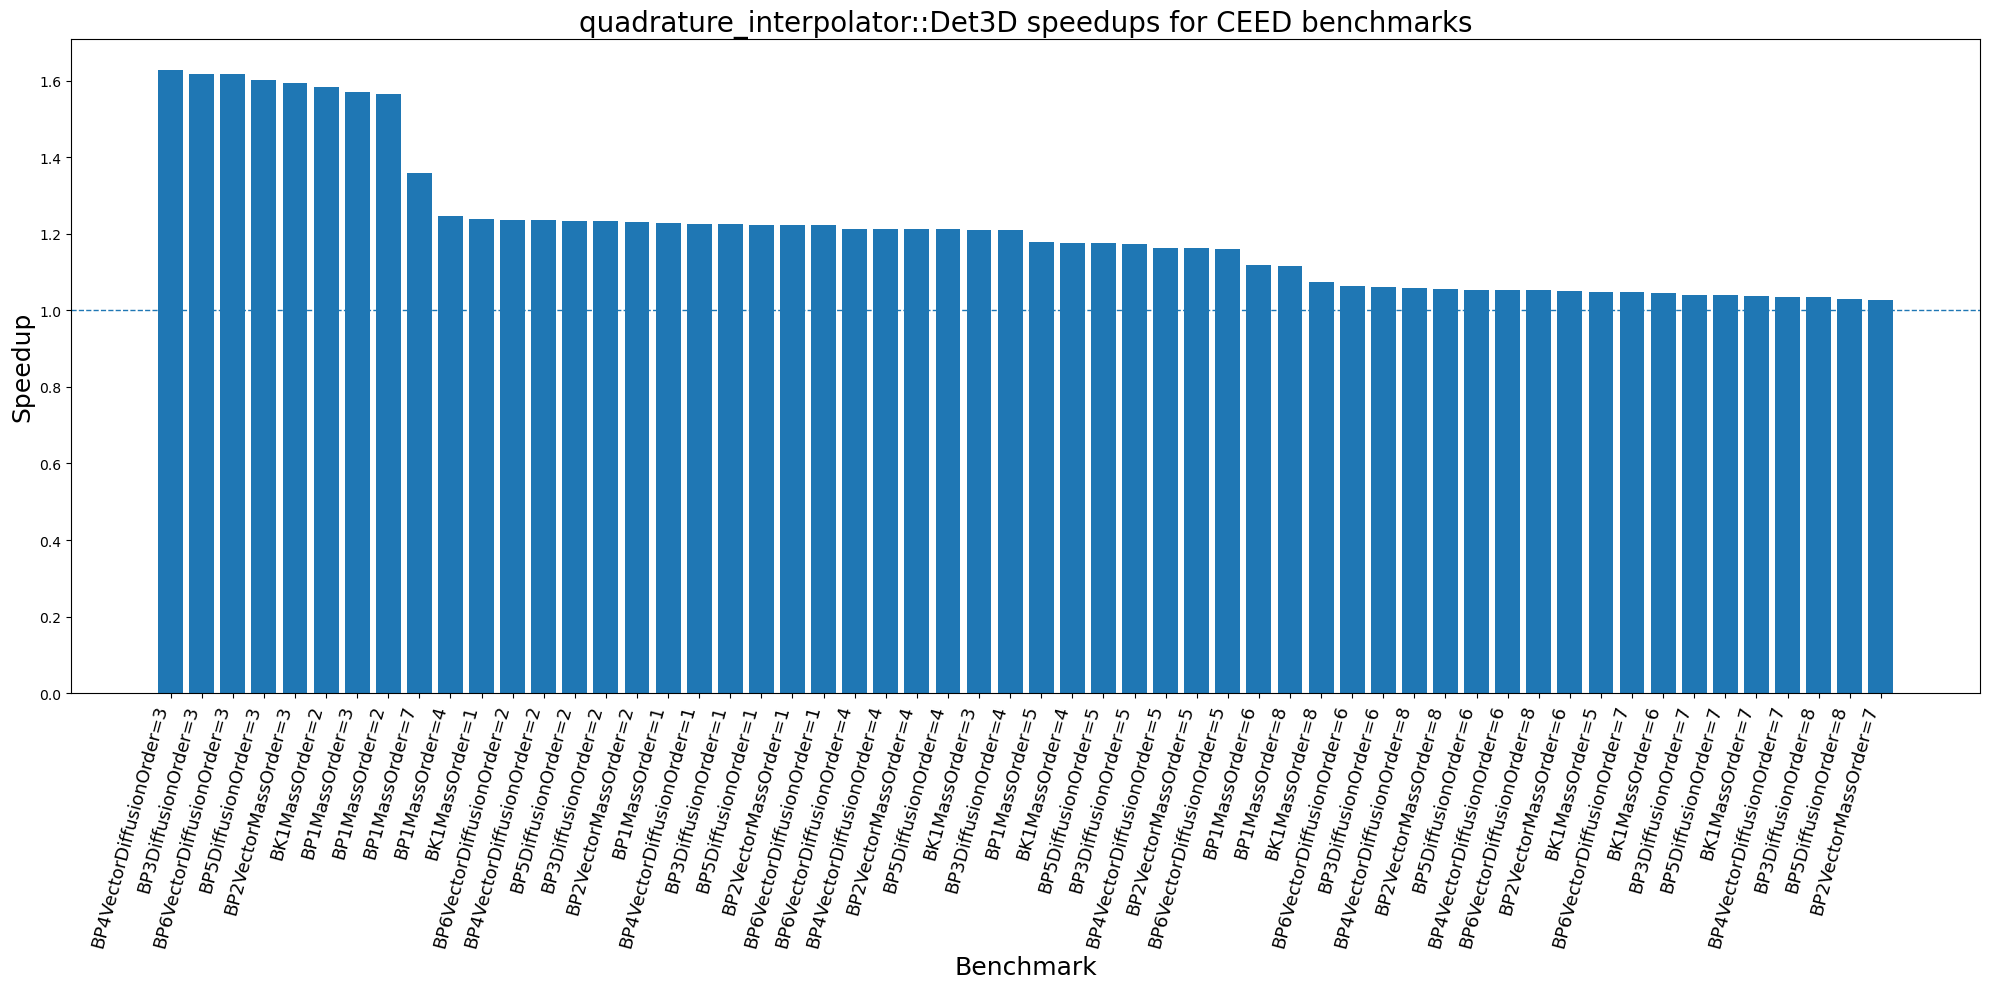

In [69]:
# Let's take a look at all the interpolator speedups

interpolator_speedups_values = all_speedups[
                                  all_speedups["KernelName"].str.contains("quadrature_interpolator") & 
                                  all_speedups["KernelName"].str.contains("Values")
                                ]

interpolator_speedups_deriv = all_speedups[
                                  all_speedups["KernelName"].str.contains("quadrature_interpolator") & 
                                  all_speedups["KernelName"].str.contains("Deriv")
                                ]

interpolator_speedups_det = all_speedups[
                                  all_speedups["KernelName"].str.contains("quadrature_interpolator") & 
                                  all_speedups["KernelName"].str.contains("Det")
                                ]

# Sort by speedup descending
def sort_and_plot_df(df, title:str, figsize_x=20, figsize_y=10):
    sorted_data = sorted(zip(df["Program"], df["Speedup"]), key=lambda x: x[1], reverse=True)
    names, speedups = zip(*sorted_data)
    
    # Plot
    plt.figure(figsize=(figsize_x, figsize_y))
    plt.bar(names, speedups)
    plt.axhline(1.0, linestyle="--", linewidth=1)

    plt.ylabel("Speedup", fontsize=18)
    plt.xlabel("Benchmark", fontsize=18)
    plt.xticks(rotation=75, ha="right", fontsize=13)
    #plt.figure(figsize=(24, 6))
    plt.title(title, fontsize=20)

    plt.tight_layout()

sort_and_plot_df(interpolator_speedups_values, "quadrature_interpolator::Values3D speedups for CEED benchmarks")
sort_and_plot_df(interpolator_speedups_deriv, "quadrature_interpolator::Derivatives3D speedups for CEED benchmarks")
sort_and_plot_df(interpolator_speedups_det, "quadrature_interpolator::Det3D speedups for CEED benchmarks")

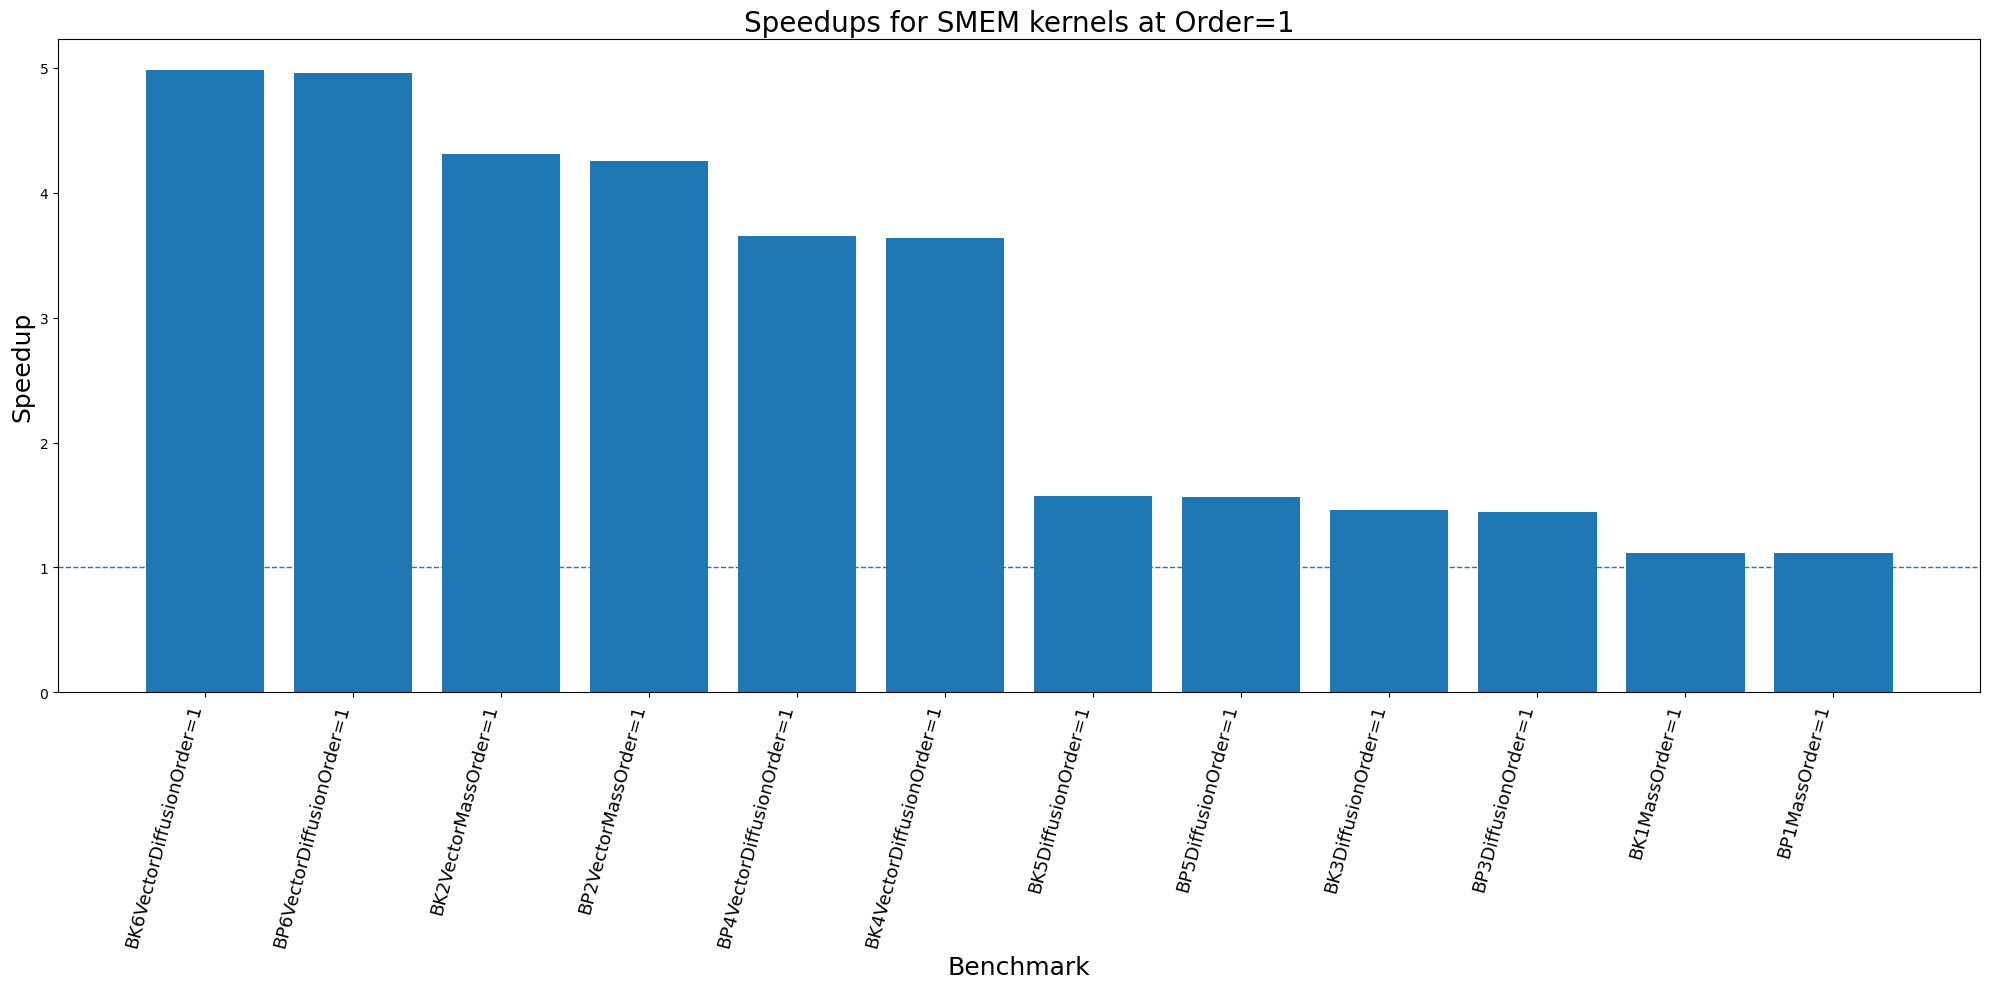

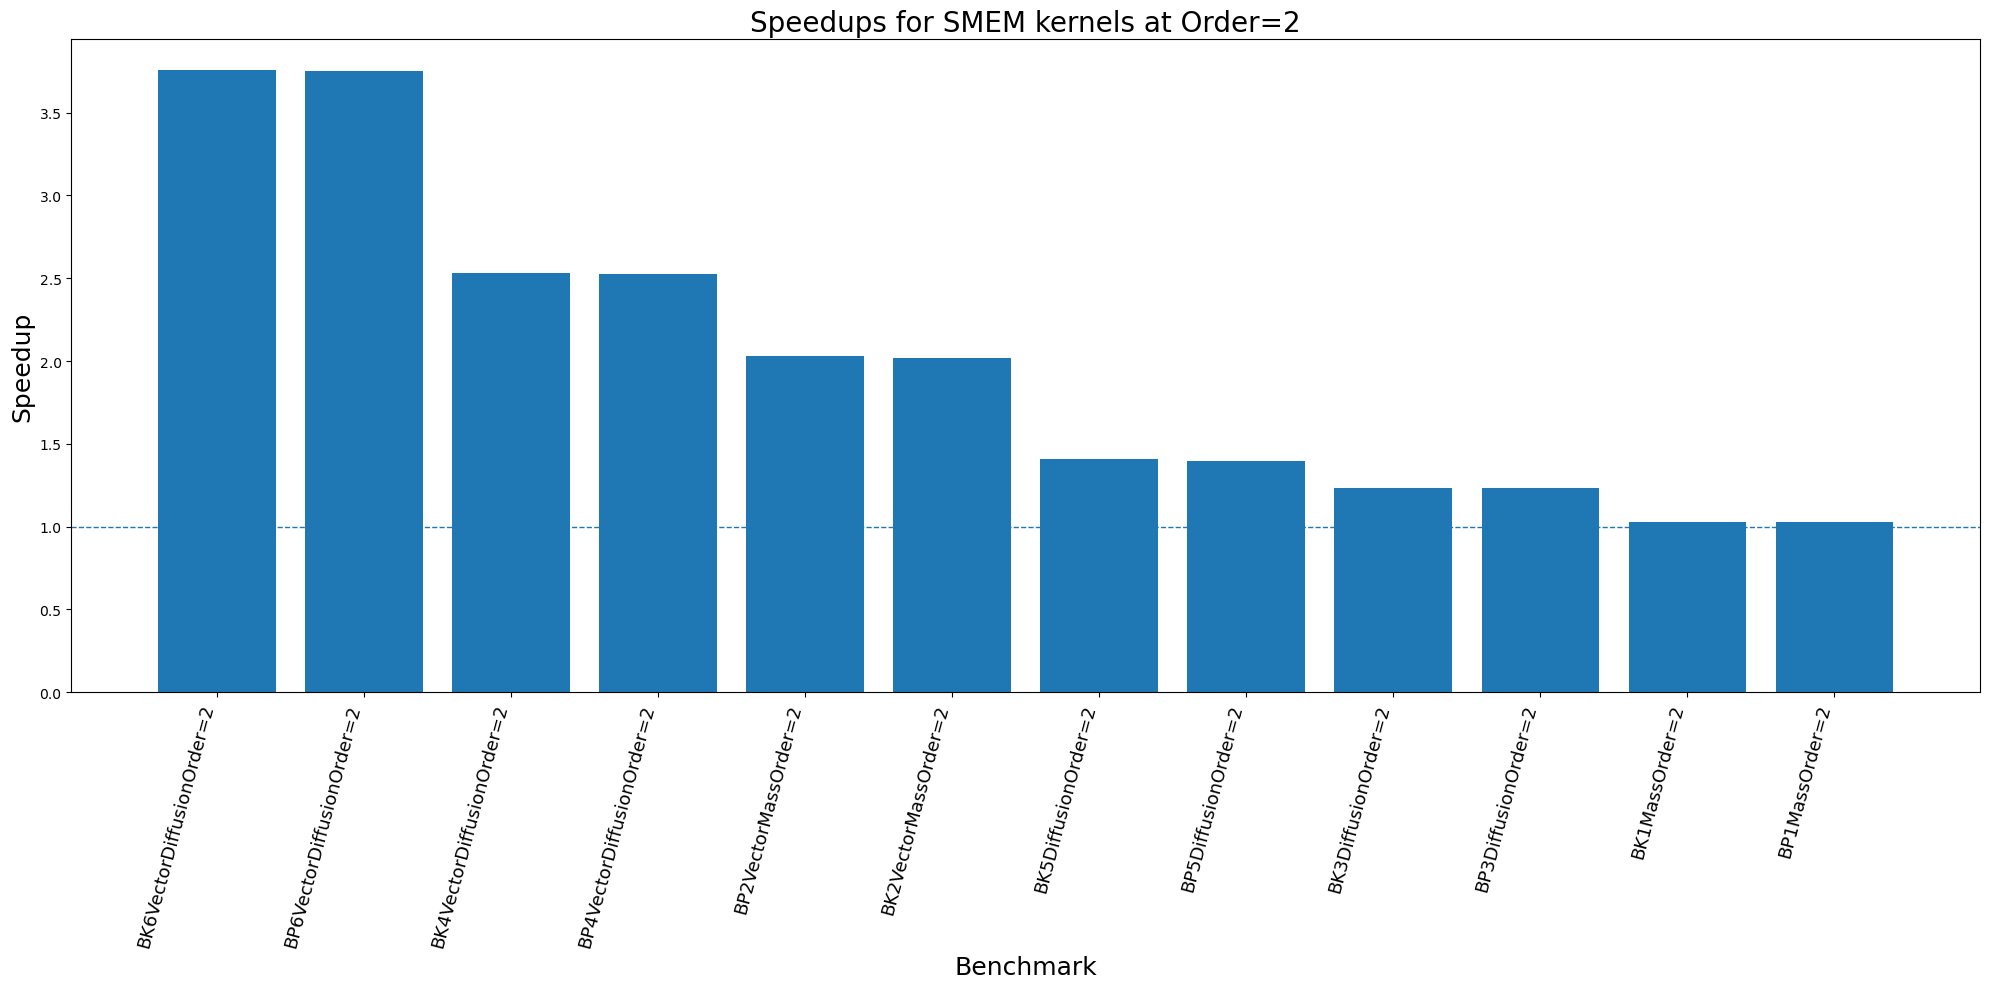

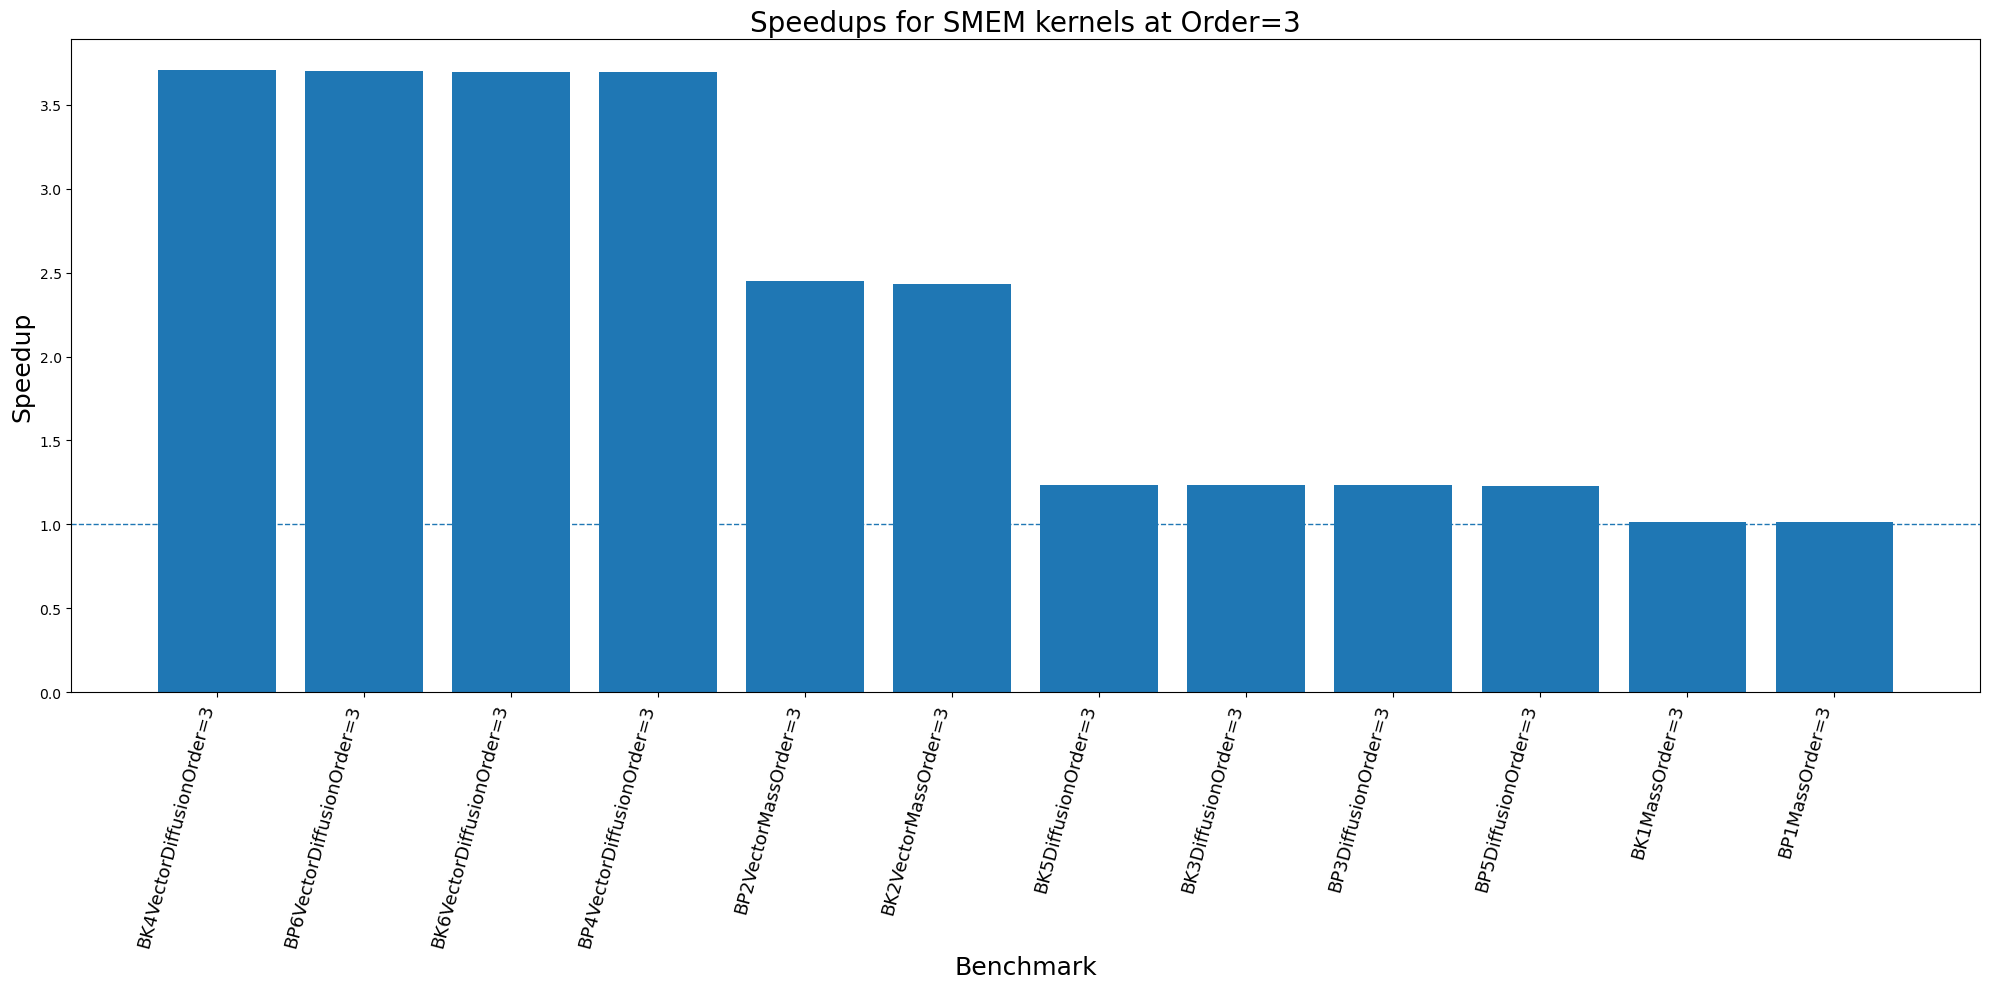

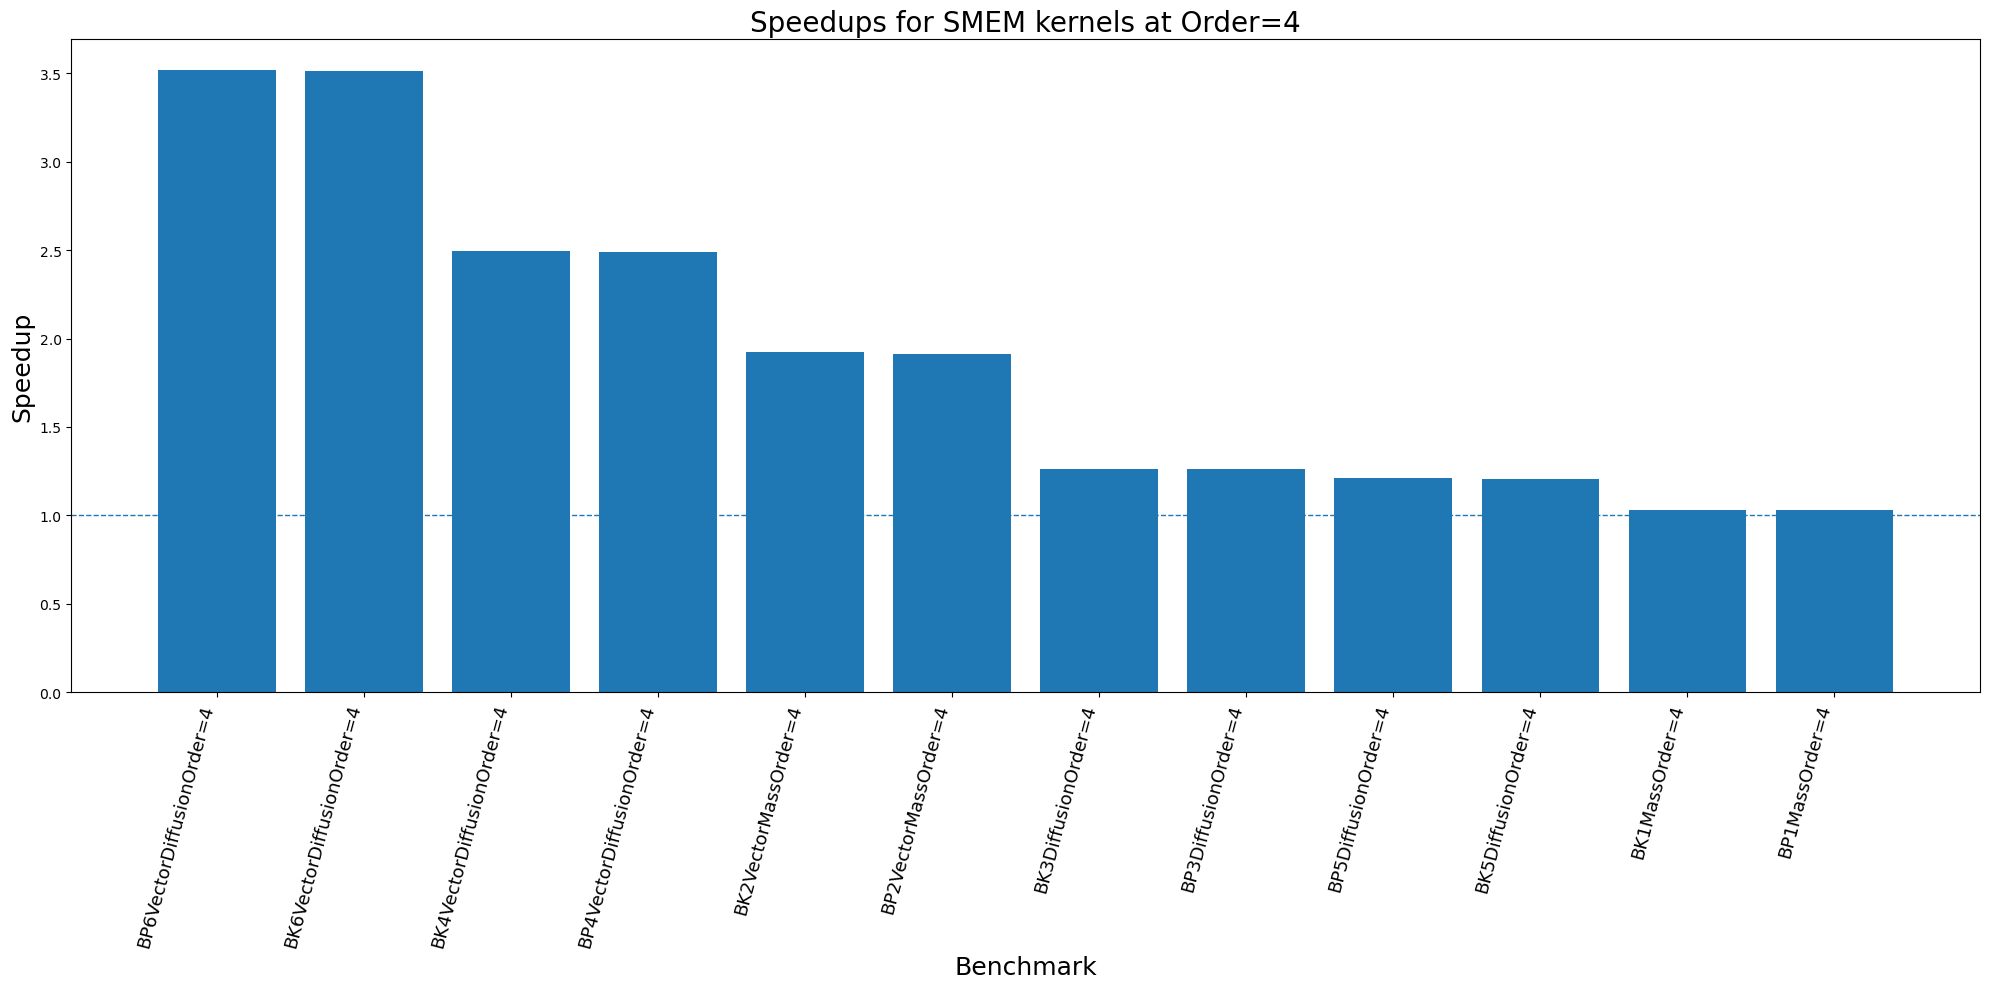

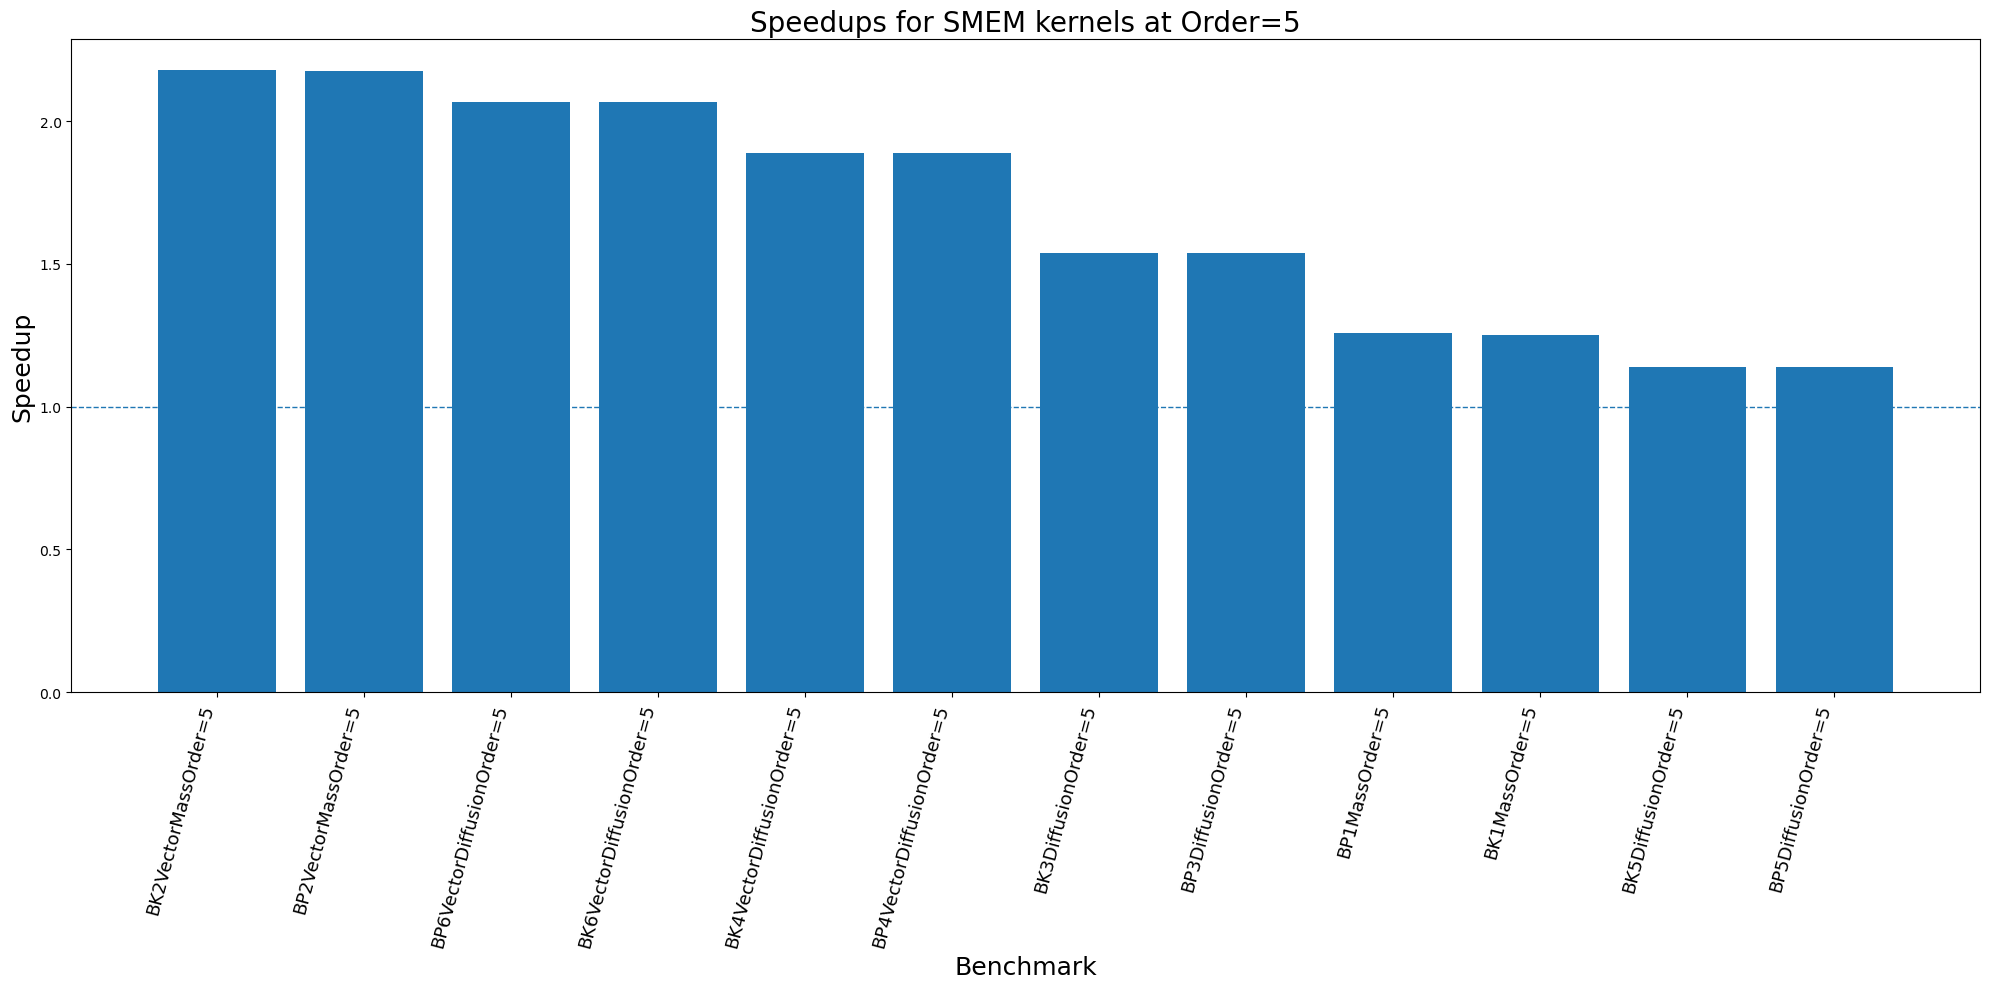

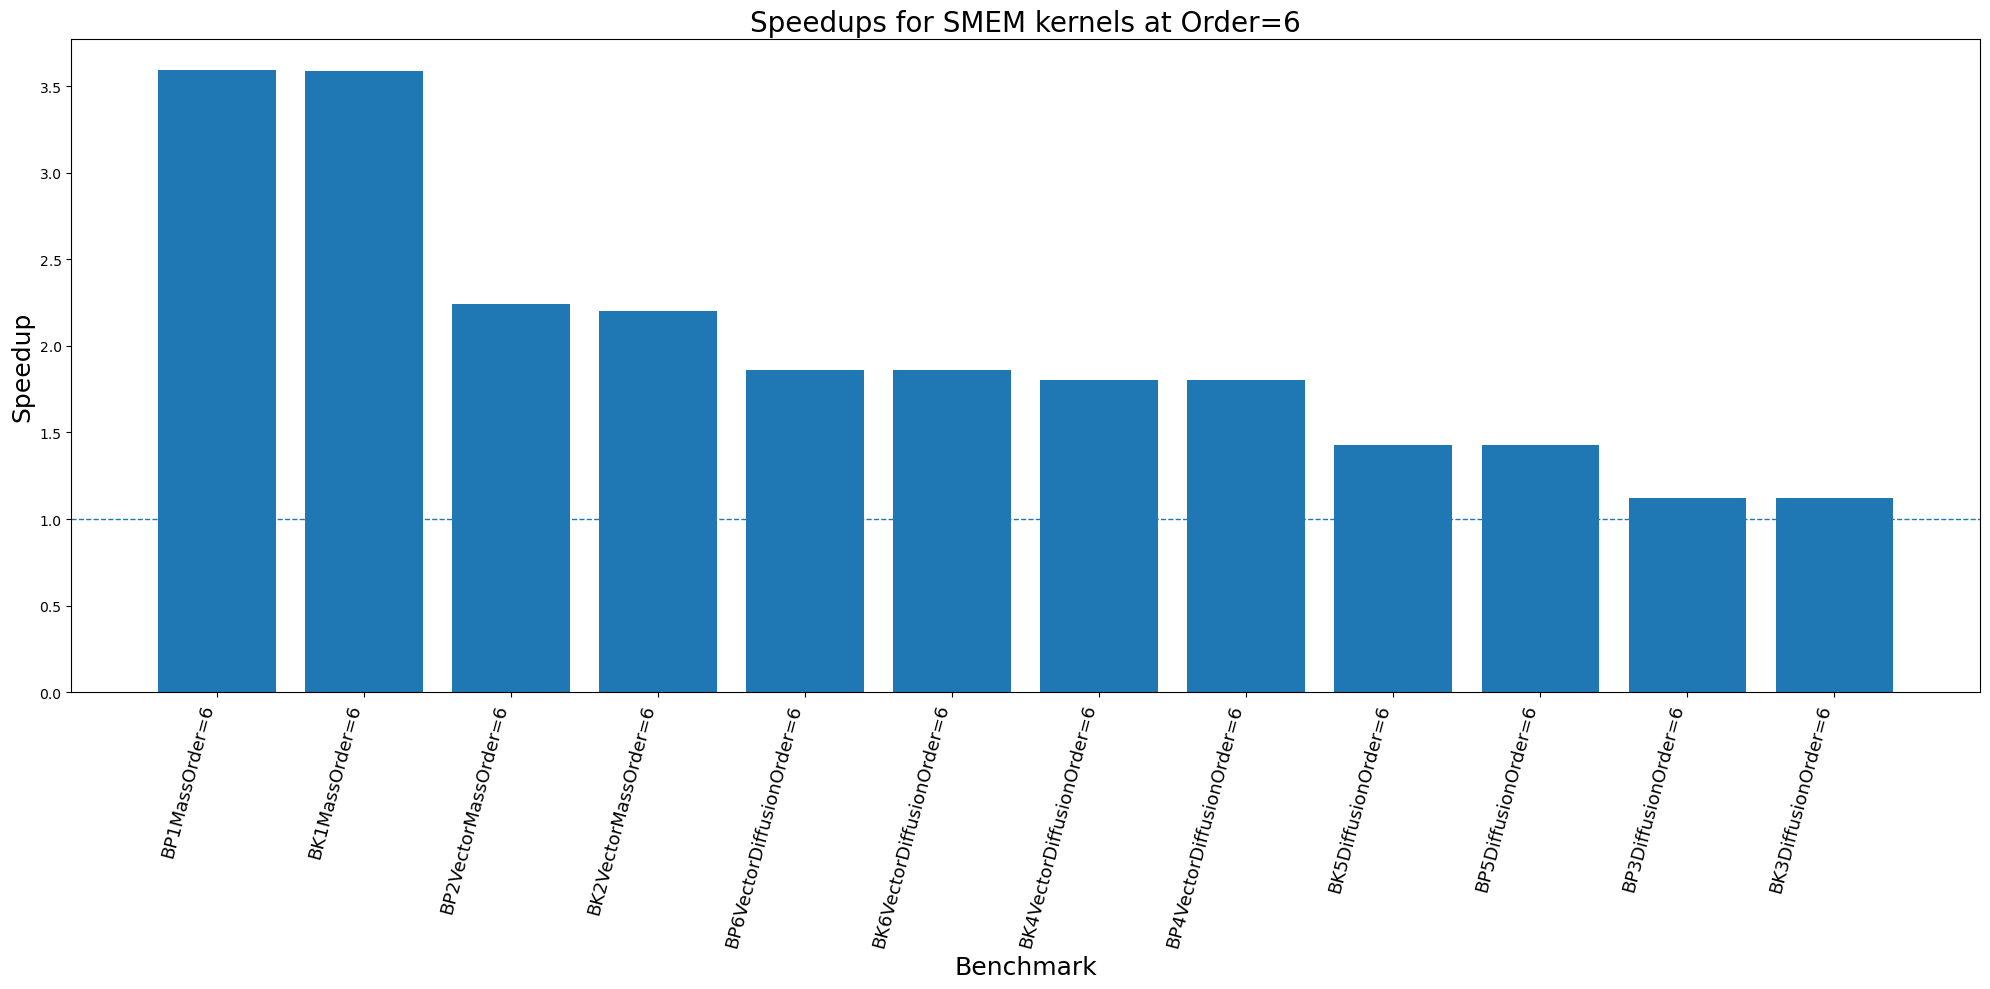

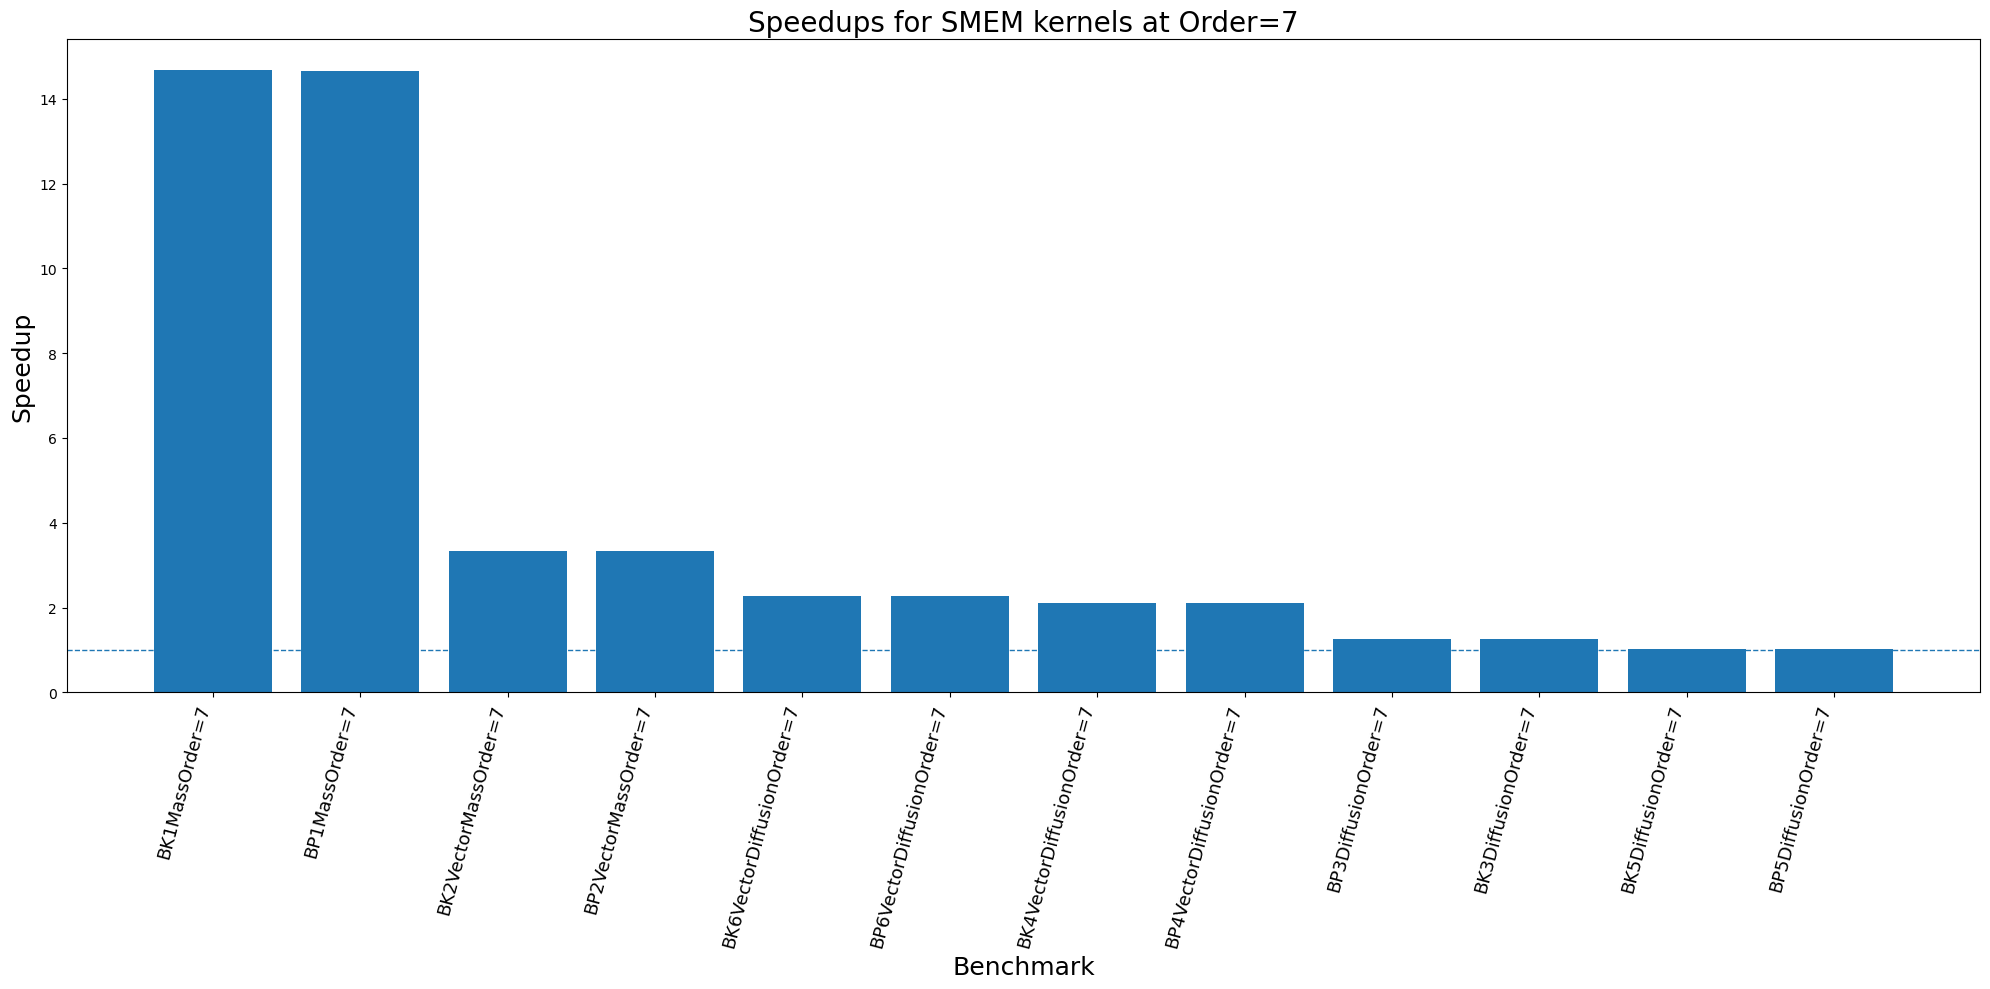

In [70]:
# group SMEM and VectorMass/VectorDiffusion speedups by order

for i in range (1, 8):
    order_df = all_speedups[(all_speedups["KernelName"].str.contains("Smem") |
                             all_speedups["KernelName"].str.contains("VectorMassApply") |
                             all_speedups["KernelName"].str.contains("VectorDiffusionApply")) &
                             all_speedups["Program"].str.contains("Order="+str(i))]
    sort_and_plot_df(order_df, "Speedups for SMEM kernels at Order="+str(i))

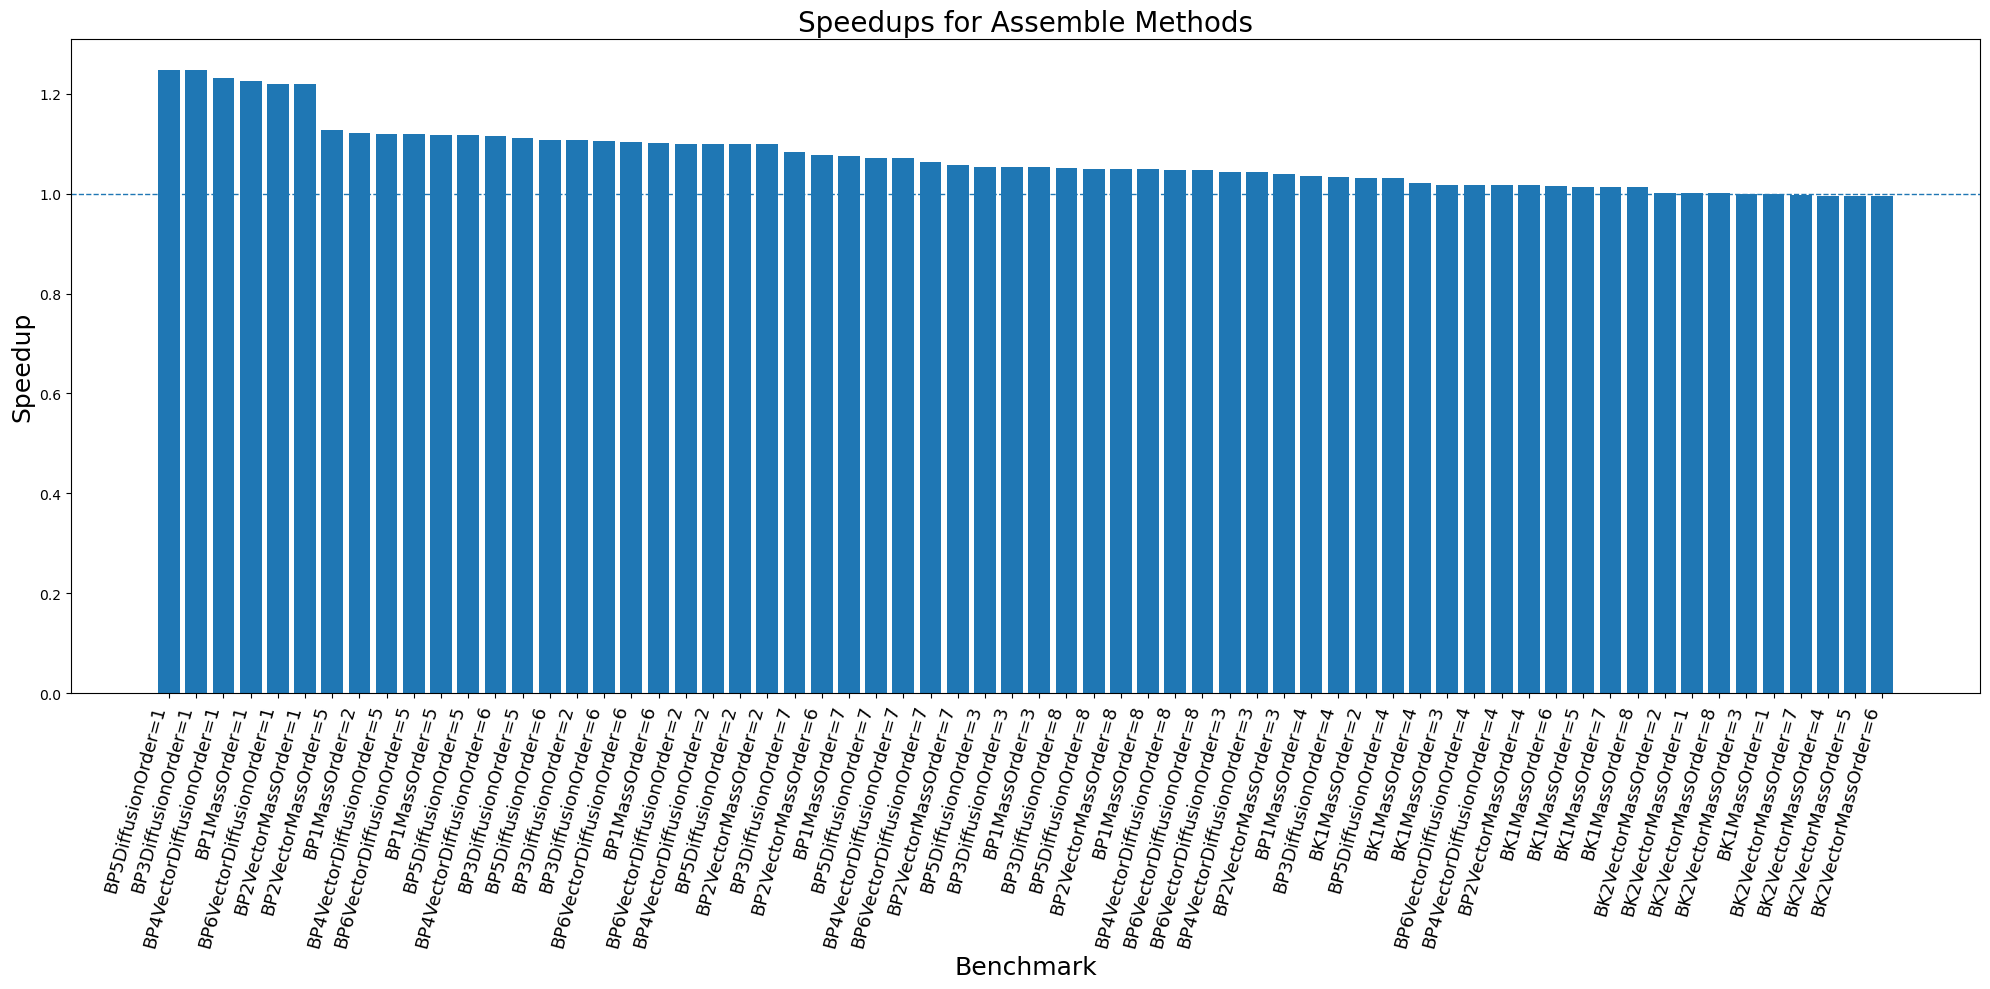

In [61]:
assembly_speedups = all_speedups[all_speedups["KernelName"].str.contains("Assemble")]
sort_and_plot_df(assembly_speedups, "Speedups for Assemble Methods")